In [1]:
import sys, time, cProfile, pstats, importlib, os, itertools
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

import pymuqUtilities as mu

import plotutil, approximation

from GaussianPosterior import *
from TransportMap import *
from DeepTransportMap import *

In [2]:
target = GaussianPosterior(noise=.05, y_measurement=[.2])

points = np.expand_dims(np.linspace(-1, 1, 300), axis=1)
target_at_points = np.array([target.Evaluate([np.array([xi])])[0][0] for xi in points])
target_at_points /= np.sum(target_at_points)*2/len(points)

def l2_error(tm) :
    approx_at_points = [tm.density(xi) for xi in points]
    approx_at_points /= np.sum(approx_at_points)*2/len(points)
    return np.sqrt(np.sum((target_at_points - approx_at_points)**2))

epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003, .0000007, .00000002]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
lambds = [m.Size() for m in multis]
print(lambds)

[3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]


In [3]:
l2_error_base = np.zeros((len(multis),))

for i in range(len(multis)) :
    tm = DeepTransportMap(1, target, [1], multis[i], 'wls', tempered_version)
    l2_error_base[i] = l2_error(tm)

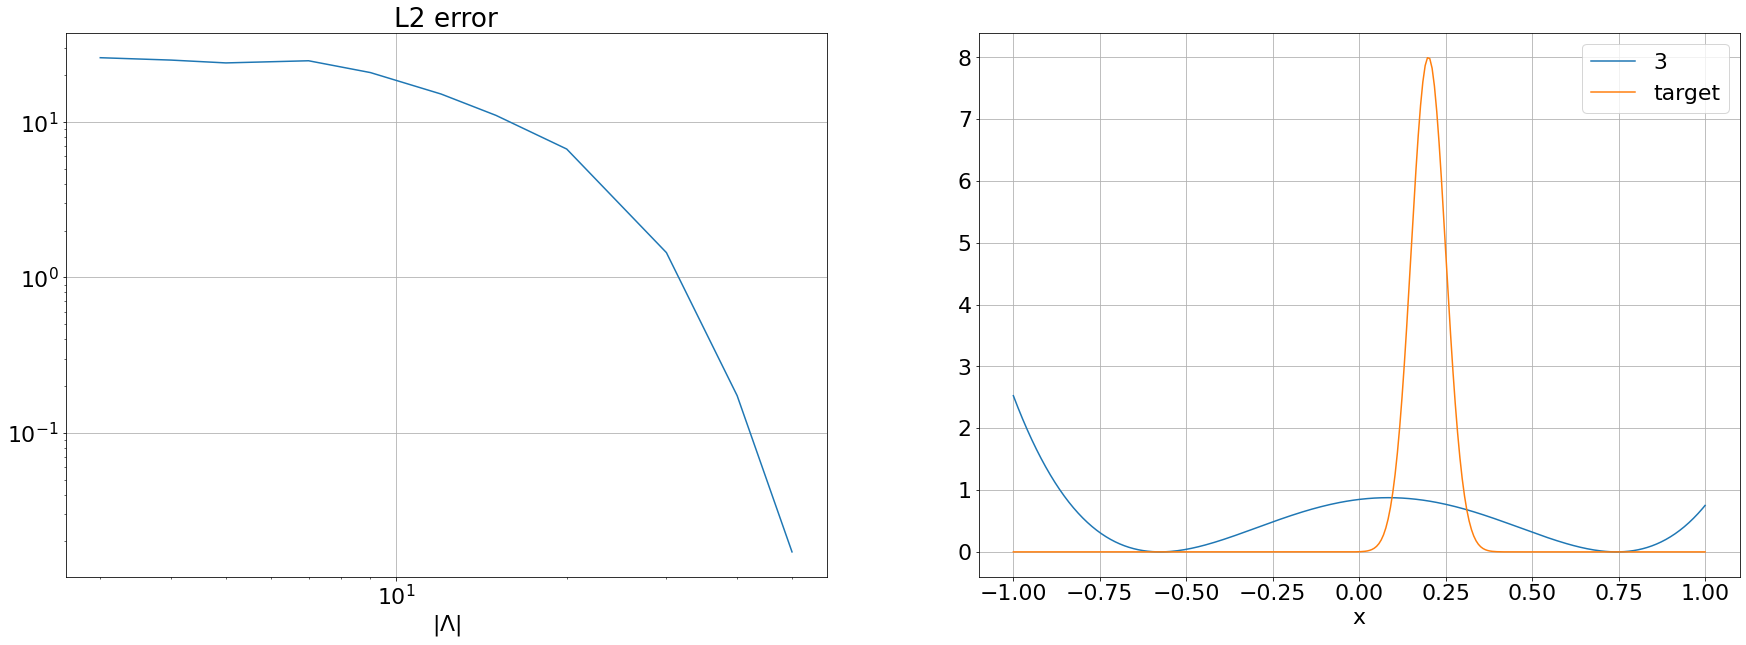

In [80]:
fig = plt.figure(figsize=(30,10))
ax1 = plotutil.get_ax(fig, 2, 1, title='L2 error', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
ax1.plot(lambds, l2_error_base, label='single')

ax1 = plotutil.get_ax(fig, 2, 2, title='', )
x = np.linspace(-1, 1, 300)
tm = DeepTransportMap(1, target, [1], multis[0], 'wls', tempered_version)
#tm = TransportMap(1, approximation.pce(target, 1, multis[-1], 'wls'), multis[-1])
approx_at_x = [tm.density([xi]) for xi in x]
approx_at_x /= np.sum(approx_at_x)*2/len(x)
ax1.plot(x, approx_at_x, label=str(multis[0].Size()))
target_at_x = np.array([target.Evaluate([np.array([xi])])[0][0] for xi in x])
target_at_x /= np.sum(target_at_x)*2/len(x)
ax1.plot(x, target_at_x, label='target')
ax1.legend()
plt.show()

In [85]:
t_temps = [[1], [.1, 1], [.01, .1, 1]] 
t_convx = [[1], [.5, 1], [.25, .5, 1]] 
l2_error_dirt_results = {'tempered' : np.zeros((len(t_temps), len(multis))), 'convex' : np.zeros((len(t_convx), len(multis)))}

def compute(indices) :
    (k,i,j) = indices
    tm = None
    if k == 'tempered' :
        tm = DeepTransportMap(1, target, t_temps[j], multis[i], 'wls', tempered_version)
    else :
        tm = DeepTransportMap(1, target, t_convx[j], multis[i], 'wls', convex_combination)
    return k, i, j, l2_error(tm)
    
with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(l2_error_dirt_results.keys(), range(len(multis))[::-1], range(len(t_temps))[::-1])
    results = list(executor.map(compute, iterable))
    for (k, i, j, l2) in results :
        l2_error_dirt_results[k][j,i] = l2

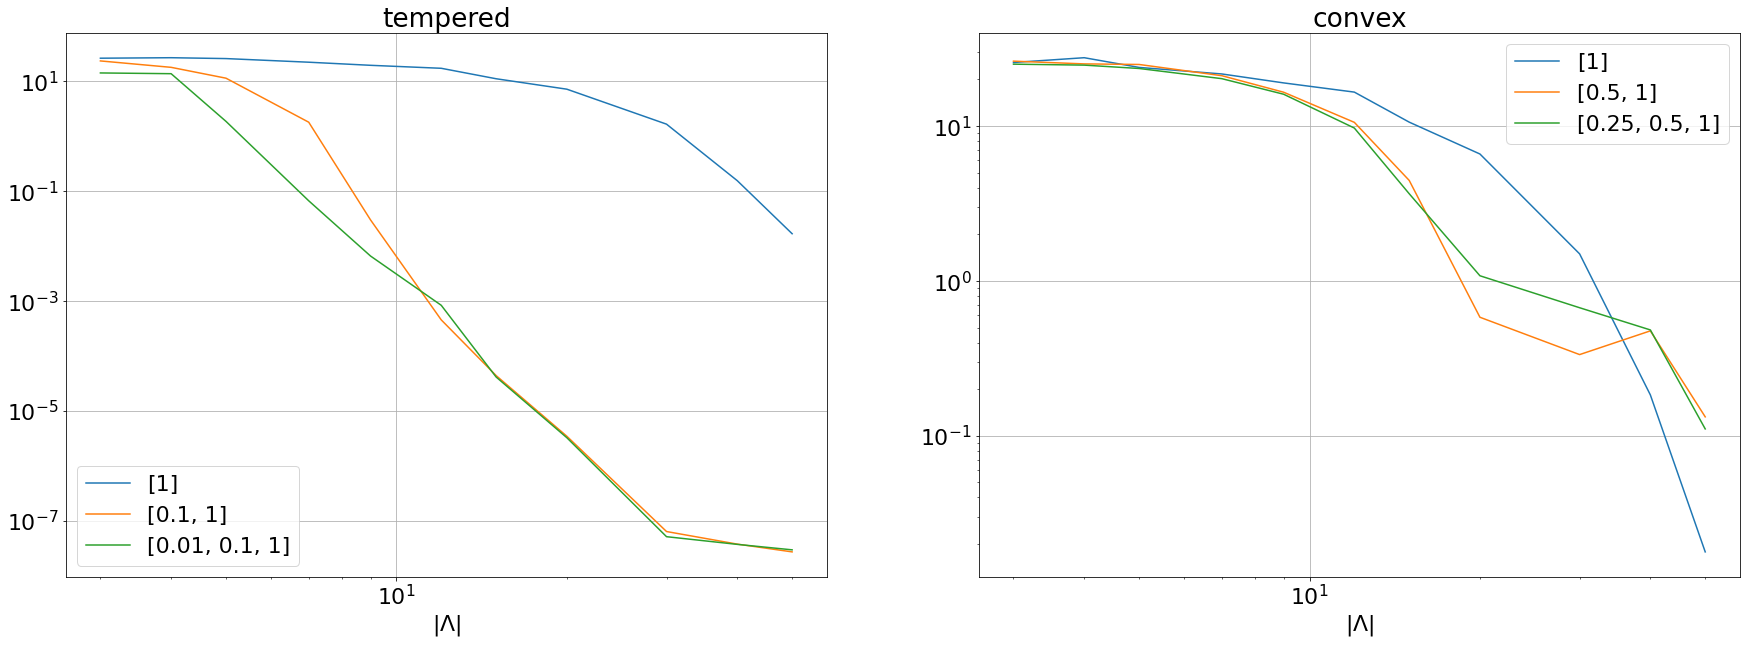

In [86]:
fig = plt.figure(figsize=(30,10))

ax1 = plotutil.get_ax(fig, 2, 1, title='tempered', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
for j in range(len(t_temps)) :
    ax1.plot(lambds, l2_error_dirt_results['tempered'][j], label=str(t_temps[j]))
ax1.legend()

ax1 = plotutil.get_ax(fig, 2, 2, title='convex', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
for j in range(len(t_convx)) :
    ax1.plot(lambds, l2_error_dirt_results['convex'][j], label=str(t_convx[j]))
ax1.legend()

plt.show()

In [6]:
t_temps = [[1], [.1, 1], [.01, .1, 1]] 
t_convx = [[1], [.1, 1], [.01, .1, 1]] 
l2_error_dirt_results = {'tempered' : np.zeros((len(t_temps), len(multis))), 'convex' : np.zeros((len(t_convx), len(multis)))}

def compute(indices) :
    (k,i,j) = indices
    tm = None
    if k == 'tempered' :
        tm = DeepTransportMap(1, target, t_temps[j], multis[i], 'wls', tempered_version)
    else :
        tm = DeepTransportMap(1, target, t_convx[j], multis[i], 'wls', convex_combination)
    return k, i, j, l2_error(tm)
    
with ProcessPoolExecutor(max_workers=7) as executor:
    iterable = itertools.product(l2_error_dirt_results.keys(), range(len(multis))[::-1], range(len(t_temps))[::-1])
    results = list(executor.map(compute, iterable))
    for (k, i, j, l2) in results :
        l2_error_dirt_results[k][j,i] = l2

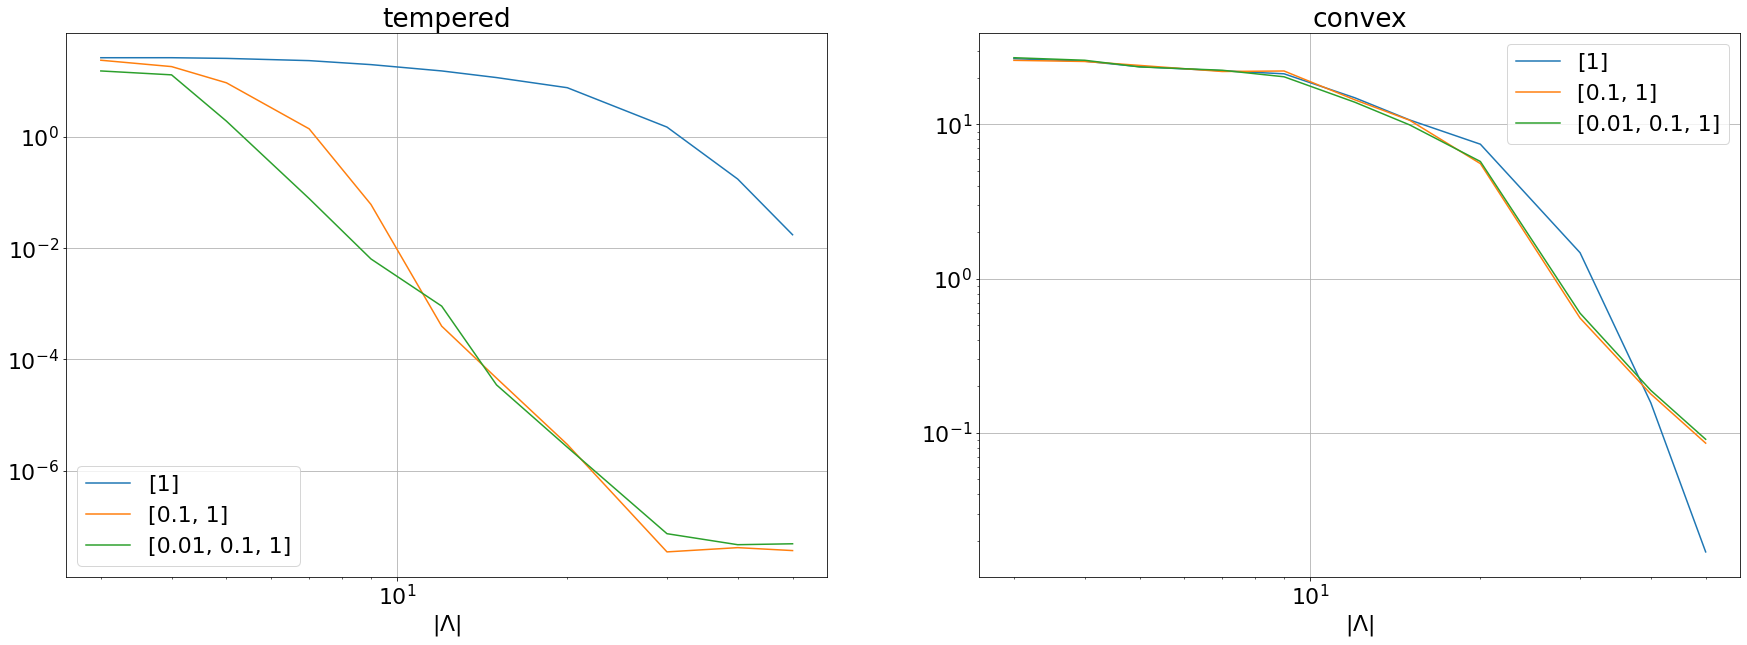

In [7]:
fig = plt.figure(figsize=(30,10))

ax1 = plotutil.get_ax(fig, 2, 1, title='tempered', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
for j in range(len(t_temps)) :
    ax1.plot(lambds, l2_error_dirt_results['tempered'][j], label=str(t_temps[j]))
ax1.legend()

ax1 = plotutil.get_ax(fig, 2, 2, title='convex', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
for j in range(len(t_convx)) :
    ax1.plot(lambds, l2_error_dirt_results['convex'][j], label=str(t_convx[j]))
ax1.legend()

plt.show()

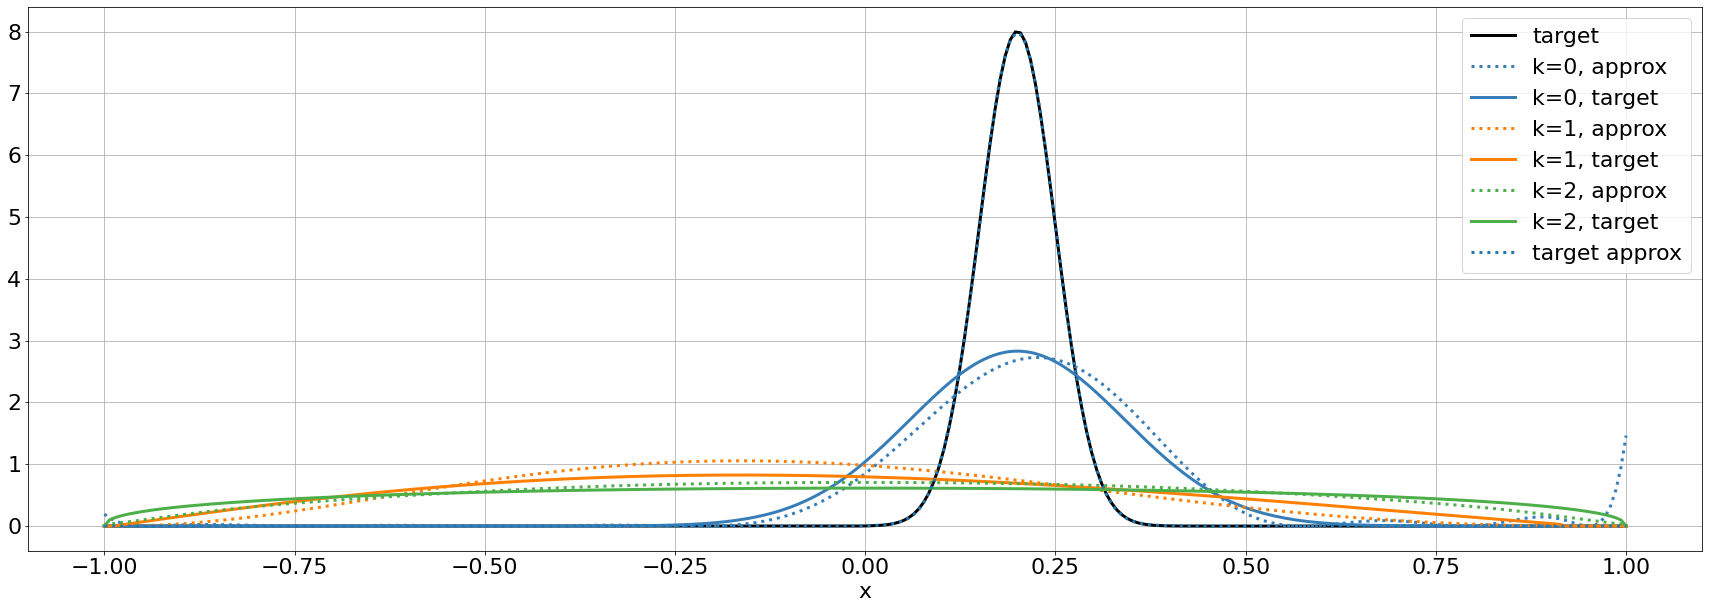

In [8]:
fig = plt.figure(figsize=(30,10))
ax1 = plotutil.get_ax(fig, 1, 1, title='')

x = np.linspace(-1, 1, 300)
tm = DeepTransportMap(1, target, [.25, .5, 1], multis[4], 'wls', tempered_version)
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    
target_at_x = np.array([target.Evaluate([np.array([xi])])[0][0] for xi in x])
target_at_x /= np.sum(target_at_x)*2/len(x)
ax1.plot(x, target_at_x, 'k', lw=3, label='target')

for i in range(len(tm.maps)) :
    
    approx_at_x = [tm.maps[i].density([xi]) for xi in x]
    approx_at_x /= np.sum(approx_at_x)*2/len(x)
    ax1.plot(x, approx_at_x, lw=3, ls=':', color=colors[i], label='k={}, approx'.format(i))
    
    target_at_x = np.array([tm.targets[i].Evaluate([np.array([xi])])[0][0] for xi in x])
    target_at_x /= np.sum(target_at_x)*2/len(x)
    ax1.plot(x, target_at_x, lw=3, color=colors[i], label='k={}, target'.format(i))

approx_at_x = [tm.density([xi]) for xi in x]
approx_at_x /= np.sum(approx_at_x)*2/len(x)
ax1.plot(x, approx_at_x, 'r', lw=3, ls=':', label='target approx')

ax1.legend()
plt.show()

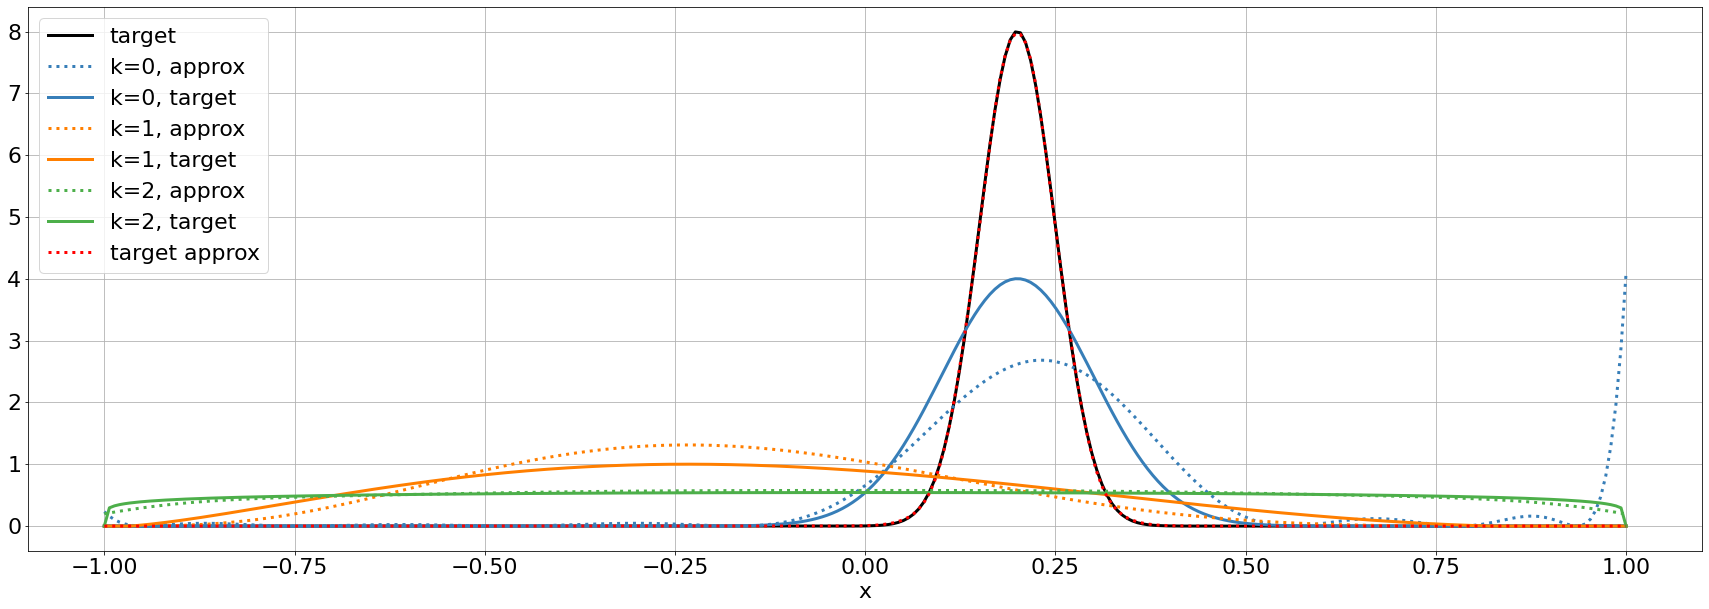

In [4]:
fig = plt.figure(figsize=(30,10))
ax1 = plotutil.get_ax(fig, 1, 1, title='')

x = np.linspace(-1, 1, 300)
tm = DeepTransportMap(1, target, [.5, .75, 1], multis[4], 'wls', tempered_version)
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    
target_at_x = np.array([target.Evaluate([np.array([xi])])[0][0] for xi in x])
target_at_x /= np.sum(target_at_x)*2/len(x)
ax1.plot(x, target_at_x, 'k', lw=3, label='target')

for i in range(len(tm.maps)) :
    
    approx_at_x = [tm.maps[i].density([xi]) for xi in x]
    approx_at_x /= np.sum(approx_at_x)*2/len(x)
    ax1.plot(x, approx_at_x, lw=3, ls=':', color=colors[i], label='k={}, approx'.format(i))
    
    target_at_x = np.array([tm.targets[i].Evaluate([np.array([xi])])[0][0] for xi in x])
    target_at_x /= np.sum(target_at_x)*2/len(x)
    ax1.plot(x, target_at_x, lw=3, color=colors[i], label='k={}, target'.format(i))

approx_at_x = [tm.density([xi]) for xi in x]
approx_at_x /= np.sum(approx_at_x)*2/len(x)
ax1.plot(x, approx_at_x, 'r', lw=3, ls=':', label='target approx')

ax1.legend()
plt.show()

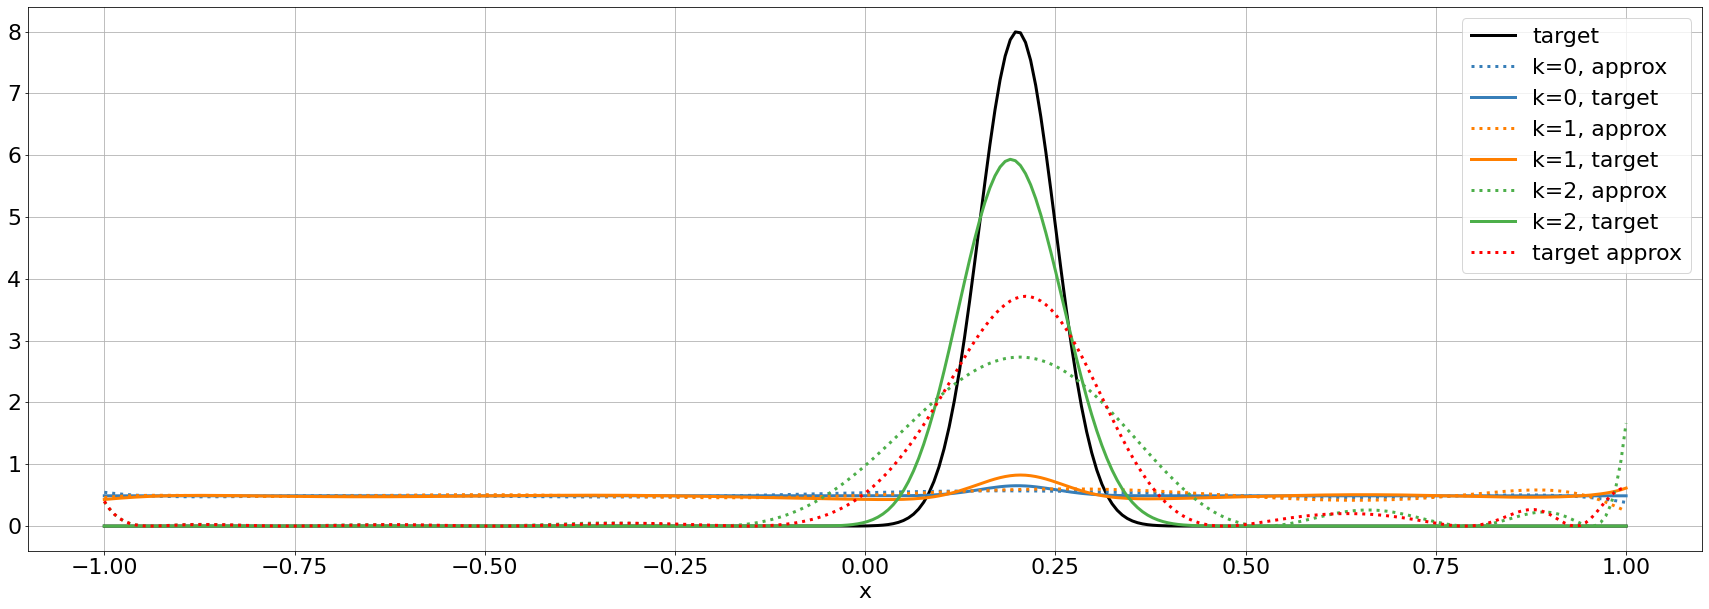

In [11]:
fig = plt.figure(figsize=(30,10))
ax1 = plotutil.get_ax(fig, 1, 1, title='')

x = np.linspace(-1, 1, 300)
tm = DeepTransportMap(1, target, [.25, .5, 1], multis[4], 'wls', convex_combination)
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    
target_at_x = np.array([target.Evaluate([np.array([xi])])[0][0] for xi in x])
target_at_x /= np.sum(target_at_x)*2/len(x)
ax1.plot(x, target_at_x, 'k', lw=3, label='target')

for i in range(len(tm.maps)) :
    
    approx_at_x = [tm.maps[i].density([xi]) for xi in x]
    approx_at_x /= np.sum(approx_at_x)*2/len(x)
    ax1.plot(x, approx_at_x, lw=3, ls=':', color=colors[i], label='k={}, approx'.format(i))
    
    target_at_x = np.array([tm.targets[i].Evaluate([np.array([xi])])[0][0]**2 for xi in x])
    target_at_x /= np.sum(target_at_x)*2/len(x)
    ax1.plot(x, target_at_x, lw=3, color=colors[i], label='k={}, target'.format(i))

approx_at_x = [tm.density([xi]) for xi in x]
approx_at_x /= np.sum(approx_at_x)*2/len(x)
ax1.plot(x, approx_at_x, 'r', lw=3, ls=':', label='target approx')

ax1.legend()
plt.show()

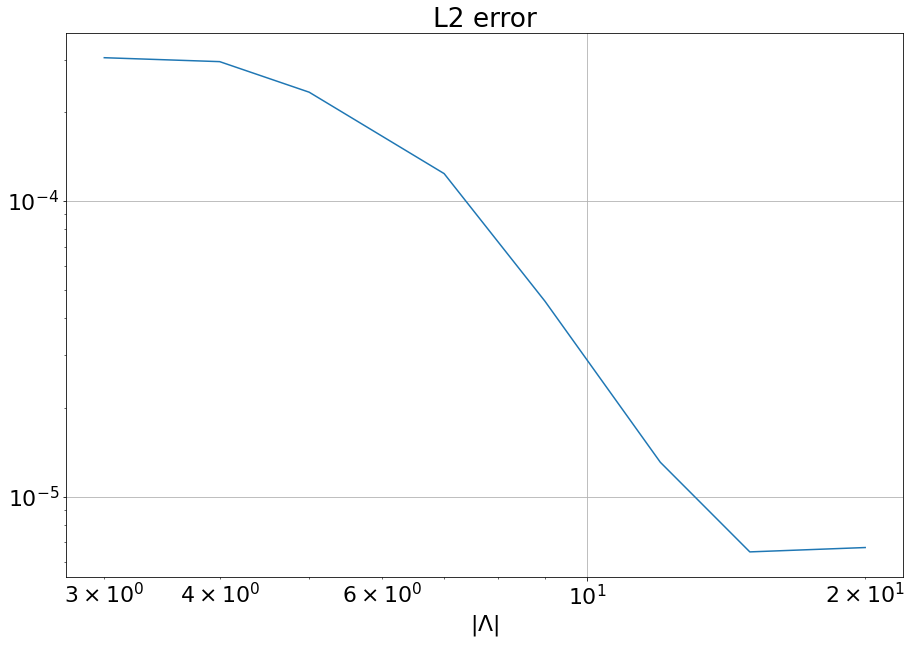

In [11]:
l2_error_dirt_convex = np.zeros((len(multis),))

for i in range(len(multis)) :
    tm = DeepTransportMap(1, target, [.5, 1], multis[i], 'wls', convex_combination)
    l2_error_dirt_convex[i] = l2_error(tm)
    
ax1 = plotutil.get_ax(plt.figure(figsize=(15,10)), 1, 1, title='L2 error', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
ax1.plot(lambds, l2_error_dirt_convex, label='single')
plt.show()